In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import time
import datetime as dt
import re
import numpy as np
import pandas as pd
from stock_scraper import get_stock_prices
import matplotlib.pyplot as plt
import seaborn as sns

from Markowitz import get_vol, opt_weight

%matplotlib inline

In [2]:
from IPython.display import HTML

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def convert_to_df(df_str):
    header = re.findall("[ , \w]+\\n", df_str)[1]
    columns = re.findall("[\w]+", header)
    number_cols = len(columns) + 1 # Including index as column
    
    n = len(columns)
    all_numbers = re.findall("[-,.,0-9]+", df_str)
    values = [float(all_numbers[i]) for i in range(len(all_numbers)) if i % number_cols != 0]
    vals_array = np.array(values).reshape((int(len(values) / n), n))
    
    tickers = re.findall('\[(.*)\]', df_str)
    
    result_df = pd.DataFrame(index=tickers, data=vals_array, columns=columns)
    
    return result_df

In [4]:
driver = webdriver.Chrome("PATH_TO_WEBDRIVER")

# Get to algorithm login page
driver.get("https://www.quantopian.com/live_algorithms/5ab08f1485587b36ca2ff733")

# Log in and proceed to live trading page
username = driver.find_element_by_id("user_email")
password = driver.find_element_by_id("user_password")
username.send_keys("USERNAME")
password.send_keys("PASSWORD")
password.send_keys(Keys.ENTER)
time.sleep(0.5)

# Go to the logs pane
driver.find_element_by_css_selector("i.fontello-icon.fontello-icon-book").click()
        
    
# Wait until logs are displayed
print("Waiting for logs...")
weights_showing = False
while not weights_showing:
    try:
        driver.find_element_by_css_selector("div.logs-footer.hidden")
    except NoSuchElementException:
        time.sleep(3)
        continue
        
    print("Done")
    weights_showing = True
    
    
# Extract weights and tickers
weights_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'WEIGHTS:')]")
weights_txt = weights_msg[0].text

tickers = re.findall('\[(.*)\]', weights_txt)
weights = re.findall('[-,.,0-9]+\\n', weights_txt)
weights = [el.replace('\n', '') for el in weights]
weights = [float(weight) for weight in weights]
       
portfolio = pd.Series(index = tickers, data = weights)
print("\nAlgo picks:\n" + str(portfolio))

# Extract scores of stocks picked
scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'FACTOR SCORES:')]")
scores_txt = scores_msg[0].text
scores_df = convert_to_df(scores_txt)

# Extract scores of bottom ranked stocks
bottom_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'BOTTOM SCORES:')]")
bottom_scores_txt = bottom_scores_msg[0].text
bottom_scores_df = convert_to_df(bottom_scores_txt)

# Extract scores of top ranked stocks
top_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'TOP SCORES:')]")
top_scores_txt = top_scores_msg[0].text
top_scores_df = convert_to_df(top_scores_txt)


print("\nPortfolio Scores:\n", scores_df)
print("\nBottom Scores:\n", bottom_scores_df)
print("\nTop Scores:\n", top_scores_df)

time.sleep(5)
driver.close()

Waiting for logs...
Done

Algo picks:
ECYT   -0.403880
CHK    -0.309826
NANO   -0.286295
OCN     0.330178
VUZI    0.332544
AYTU    0.337278
dtype: float64

Portfolio Scores:
       composite  momentum  sentiment   value
ECYT    -1.0232   -2.1783    -0.2183 -0.3231
CHK     -0.4987   -1.0036    -0.1417 -0.2028
NANO    -0.4721   -1.0084    -0.0755 -0.1925
OCN      0.5150    0.0000     0.3035  1.9680
VUZI     1.3226    2.4555    -0.0060  1.7138
AYTU     0.7917    1.6515     0.3277  0.0000

Bottom Scores:
       composite  momentum  sentiment   value
ECYT    -1.0232   -2.1783    -0.2183 -0.3231
CHK     -0.4987   -1.0036    -0.1417 -0.2028
NANO    -0.4721   -1.0084    -0.0755 -0.1925
B       -0.3018    0.0000    -0.4009 -0.7070
MDT     -0.3179    0.0000    -0.2947 -1.0000
MOD     -0.2842    0.0000    -0.3885 -0.6441
SQ      -0.4021   -1.0204     0.0152  0.0000
BTG     -0.2092    0.0000    -0.4330 -0.1799
GS      -0.1593    0.0000    -0.2979 -0.2010
ESXB    -0.4606   -1.0017    -0.0052 -0.289

# Analysis of Portfolio Picks

Raw Portfolio Picks


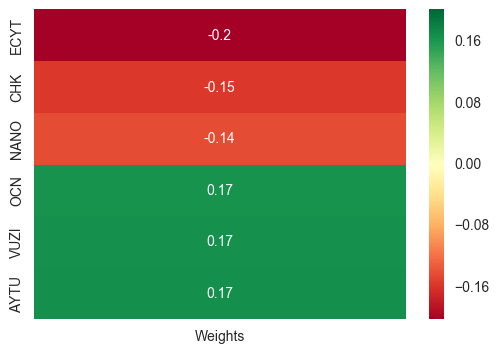

In [5]:
print("Raw Portfolio Picks")
sns.heatmap(pd.DataFrame(portfolio/2, columns=['Weights']), annot=True, cmap='RdYlGn')

Portfolio Factor Analysis


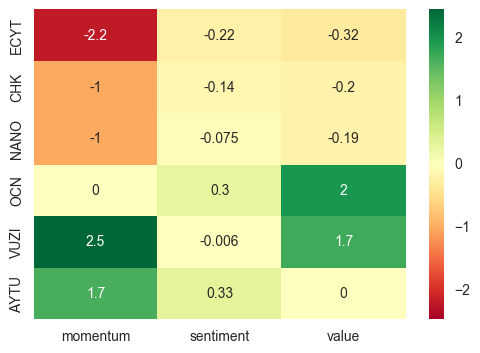

In [6]:
print("Portfolio Factor Analysis")
sns.heatmap(scores_df.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [7]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(portfolio.index, str(start), str(today))['Adj Close']

Succeeded in 2.26s after 2 attempts


In [8]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)

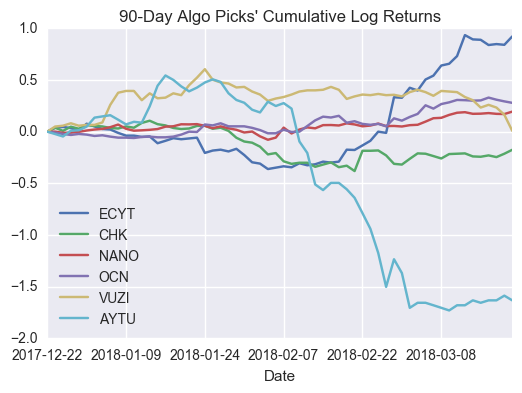

In [9]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)

cum_returns = (1 + rets.fillna(0)).cumprod()
np.log(cum_returns).plot(title='%d-Day Algo Picks\' Cumulative Log Returns' % COVAR_LOOKBACK)


2D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


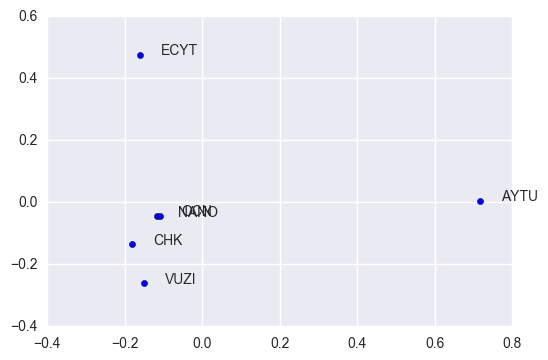

In [10]:
U, s, V = np.linalg.svd(A)
V = V.T
M = A @ V[:, :2]
print("2D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(M[:, 0], M[:, 1])
for i in range(len(M)):
    ax.annotate(A.index[i], xy=(M[i, 0],M[i, 1]), xytext=(15,0), textcoords='offset points')

3D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


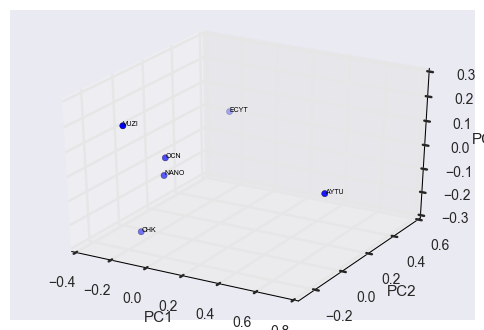

In [11]:
# Now let's project on 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

M_3D = A @ V[:, :3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = M_3D[:, 0]
ys = M_3D[:, 1]
zs = M_3D[:, 2]

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.scatter(xs, ys, zs)

for i in range(len(A)): #plot each point + it's index as text above
    ax.text(M_3D[i,0],M_3D[i,1],M_3D[i,2],  A.index[i], size=5, zorder=1,  
    color='k') 

print("3D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


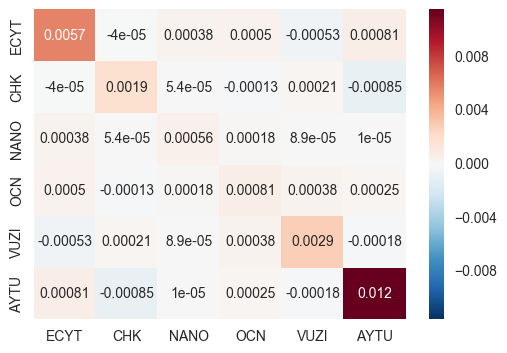

In [12]:
cov_mat = rets.dropna().cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=True, center=0)

In [13]:
from sklearn.cluster import KMeans
def corr_matrix_data(X, num_clusters=3, x_labels = False):
    # demean the data
    X_demeaned = X - np.mean(X, 0) 
    
    _, _, V = np.linalg.svd(X_demeaned)
    V = V.T
    
    # get projected data
    X_proj = X_demeaned @ V[:, :num_clusters]
    
    # do some k-means clustering to identify which points are in which cluster
    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X_proj)
    
    # sort data based on identified clusters 
    t = X.copy()
    t['cluster'] = clusters
    t = t.sort_values("cluster")
    t = t.drop("cluster", 1)
    plt.imshow(t.T.corr(), "hot")
    plt.colorbar()
    plt.grid(False)
    plt.yticks(range(len(X)), t.index)
    if x_labels:
        plt.xticks(range(len(X)), t.index)
    

Unclustered Correlation Matrix Heat Map


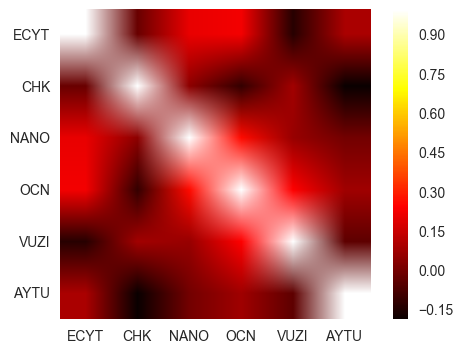

In [14]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.xticks(range(rets.shape[1]), rets.columns)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

2-Clustered Correlation Matrix Heat Map


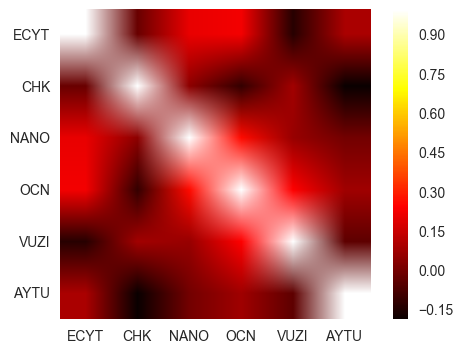

In [15]:
NUM_CLUSTERS = 2
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS, x_labels=True)

In [16]:
return_sd = pd.DataFrame(index = portfolio.index)
return_sd['E[r]'] = scores_df['composite']
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [17]:
def get_MVP(mu_vec, cov_mat, mark_vols, mark_rets, stocks):
    MVP_index = np.argmin(mark_vols)
    MVP = opt_weight(mark_rets[MVP_index], cov_mat, mu_vec)
    MVP_series = pd.Series(index=stocks, data=MVP.reshape((len(MVP))))
    print("Minimum Variance Portfolio:\n" + str(MVP_series.sort_values()))
    
    return MVP_series

In [18]:
def get_market_port(mu_vec, cov_mat, mark_vols, mark_rets, rf, stocks):
    derivatives = []
    for i in range(1, len(mark_rets) - 1):
        derivative = (mark_rets[i + 1] - mark_rets[i - 1]) / (mark_vols[i + 1] - mark_vols[i - 1])
        derivatives.append(derivative)
        
    cap_mkts_slopes = []
    for i in range(1, len(mark_rets) - 1):
        cap_mkts_slope = (mark_rets[i] - rf) / mark_vols[i]
        cap_mkts_slopes.append(cap_mkts_slope)
        
    MVP_index = np.argmax(derivatives)
    market_portfolio_index = np.argmin((np.array(derivatives[MVP_index:]) - np.array(cap_mkts_slopes[MVP_index:]))**2)
    market_portfolio_index += MVP_index
    market_portfolio_ret = mark_rets[market_portfolio_index - 1]
    market_portfolio = opt_weight(market_portfolio_ret, cov_mat, mu_vec)
    market_port_series = pd.Series(index=stocks, data=market_portfolio.reshape((len(market_portfolio))))
    
    cap_mkt_slope = cap_mkts_slopes[market_portfolio_index]
    
    print("Market Portfolio, assuming risk-free rate of %.2f:\n" % rf + str(market_port_series.sort_values()))
    
    return market_port_series, cap_mkt_slope
    

In [19]:
RF_RATE = 0.03

def plot_eff_front(mu_vec, cov_mat, stocks):
    mu_vec = mu_vec.reshape((len(mu_vec), 1))
    rets = np.linspace(-2 * np.abs(min(mu_vec)), 2*np.abs(max(mu_vec)), 100)
    vols = [get_vol(opt_weight(r, cov_mat, mu_vec), cov_mat) for r in rets]
    
    MVP = get_MVP(mu_vec, cov_mat, vols, rets, stocks)
    market_port, cap_mkt_slope = get_market_port(mu_vec, cov_mat, vols, rets, RF_RATE, stocks)
    x = np.linspace(0, max(vols), 100)
    cap_mkts_line = [RF_RATE + cap_mkt_slope*x for x in x]
    
    plt.plot(vols, rets)
    plt.plot(x, cap_mkts_line)
    plt.xlim(xmin=0)
    
    return MVP, market_port

In [20]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
         E[r]       vol
ECYT -1.0232  0.075745
CHK  -0.4987  0.043180
NANO -0.4721  0.023638
OCN   0.5150  0.028457
VUZI  1.3226  0.053430
AYTU  0.7917  0.107459


Minimum Variance Portfolio:
ECYT    0.000252
AYTU    0.035258
VUZI    0.049890
CHK     0.185643
OCN     0.290807
NANO    0.438150
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
NANO   -0.997691
ECYT   -0.224660
CHK    -0.077359
AYTU    0.131230
VUZI    0.672247
OCN     1.496233
dtype: float64


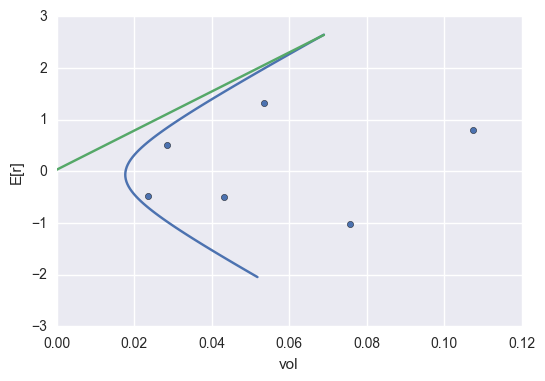

In [21]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP1, market_port1 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), portfolio.index)

In [22]:
def unlever_portfolio(portfolio):
    unlevered_port = portfolio.copy()
    short_sum = 0
    long_sum = 0
    for weight in unlevered_port:
        if weight < 0:
            short_sum -= weight
        else:
            long_sum += weight
            
    for i in range(len(unlevered_port)):
        if unlevered_port[i] < 0:
            unlevered_port[i] /= short_sum
        else:
            unlevered_port[i] /= long_sum

    if short_sum != 0:
        unlevered_port /= 2
            
    return unlevered_port

Unlevered Minimum Variance Portfolio


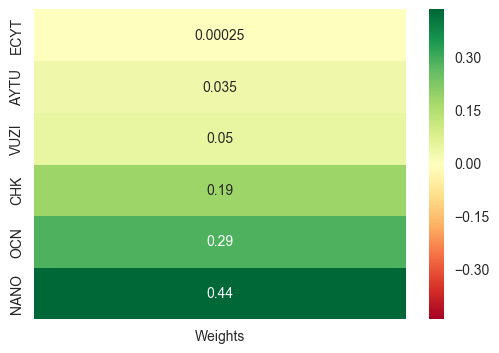

In [23]:
unlevered_MVP1 = unlever_portfolio(MVP1)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


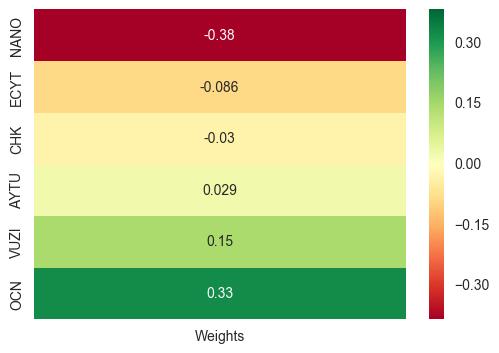

In [24]:
unlevered_market_port1 = unlever_portfolio(market_port1)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

# Analysis of Other Top and Bottom Stocks

In [25]:
all_scores = pd.concat([bottom_scores_df, top_scores_df], axis=0)

Factor Analysis


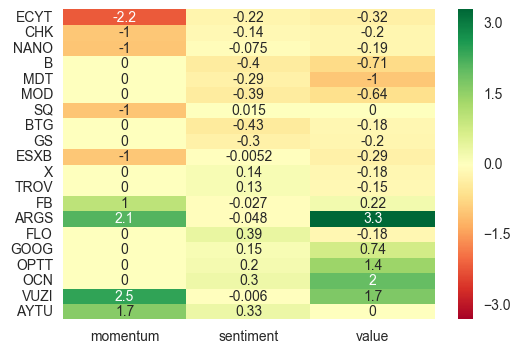

In [26]:
print("Factor Analysis")
sns.heatmap(all_scores.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [27]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(all_scores.index, str(start), str(today))['Adj Close']

Succeeded in 3.21s after 2 attempts


In [28]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)

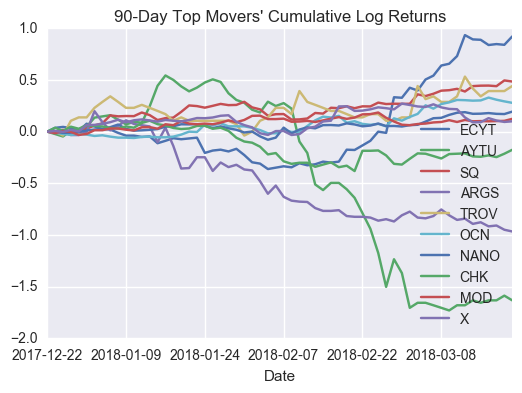

In [29]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)


cum_returns = (1 + rets.fillna(0)).cumprod()
top_movers = np.abs(cum_returns.iloc[-1] - 1).sort_values(ascending=False).head(10).index
np.log(cum_returns)[top_movers].plot(title='%d-Day Top Movers\' Cumulative Log Returns' % COVAR_LOOKBACK)


2D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


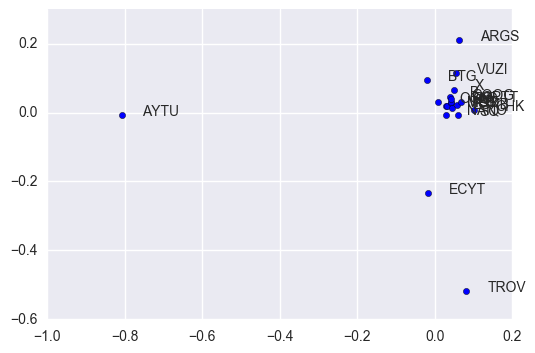

In [30]:
U, s, V = np.linalg.svd(A)
V = V.T
M = A @ V[:, :2]
print("2D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(M[:, 0], M[:, 1])
for i in range(len(M)):
    ax.annotate(A.index[i], xy=(M[i, 0],M[i, 1]), xytext=(15,0), textcoords='offset points')

3D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


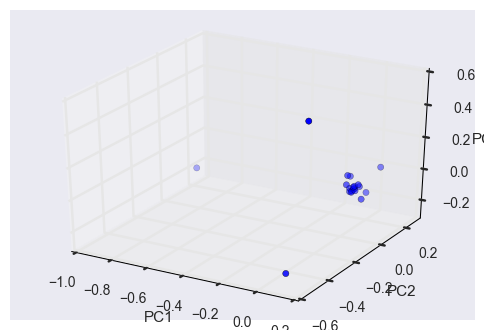

In [31]:
# Now let's project on 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

M_3D = A @ V[:, :3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = M_3D[:, 0]
ys = M_3D[:, 1]
zs = M_3D[:, 2]

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.scatter(xs, ys, zs)
    
print("3D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


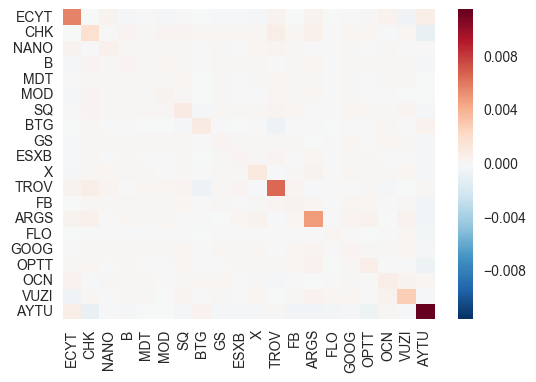

In [32]:
cov_mat = rets.dropna().cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=False, center=0)

Unclustered Correlation Matrix Heat Map


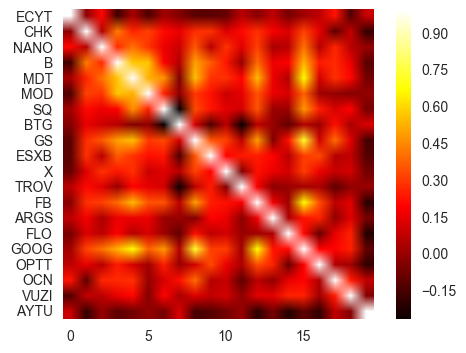

In [33]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

3-Clustered Correlation Matrix Heat Map


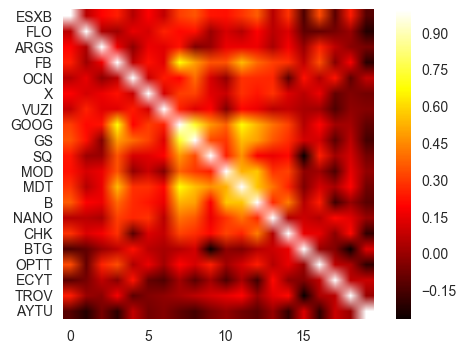

In [37]:
NUM_CLUSTERS = 3
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS)

In [38]:
return_sd = pd.DataFrame(index = all_scores.index)
return_sd['E[r]'] = all_scores['composite']
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [39]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
         E[r]       vol
ECYT -1.0232  0.075745
CHK  -0.4987  0.043180
NANO -0.4721  0.023638
B    -0.3018  0.016471
MDT  -0.3179  0.012446
MOD  -0.2842  0.019885
SQ   -0.4021  0.031264
BTG  -0.2092  0.031392
GS   -0.1593  0.016636
ESXB -0.4606  0.017306
X     0.0224  0.033788
TROV  0.0225  0.081668
FB    0.4387  0.020397
ARGS  1.4990  0.069823
FLO   0.1191  0.014109
GOOG  0.2088  0.017601
OPTT  0.3614  0.027360
OCN   0.5150  0.028457
VUZI  1.3226  0.053430
AYTU  0.7917  0.107459


Minimum Variance Portfolio:
GOOG   -0.236671
OCN    -0.083029
CHK    -0.044758
MOD    -0.025162
X      -0.017999
VUZI   -0.008582
TROV   -0.006692
ARGS   -0.001326
NANO    0.009786
AYTU    0.018517
ECYT    0.021309
SQ      0.034086
B       0.048260
OPTT    0.058423
FB      0.060874
GS      0.088395
BTG     0.112336
ESXB    0.144175
FLO     0.395913
MDT     0.432144
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
B      -1.079778
GS     -0.904491
MDT    -0.705945
SQ     -0.457339
ESXB   -0.453302
NANO   -0.403730
BTG    -0.215522
ECYT   -0.150686
ARGS    0.021480
VUZI    0.045965
TROV    0.065338
CHK     0.067133
AYTU    0.087464
X       0.100373
MOD     0.464114
OPTT    0.530415
FB      0.708270
OCN     0.845859
FLO     0.877384
GOOG    1.556999
dtype: float64


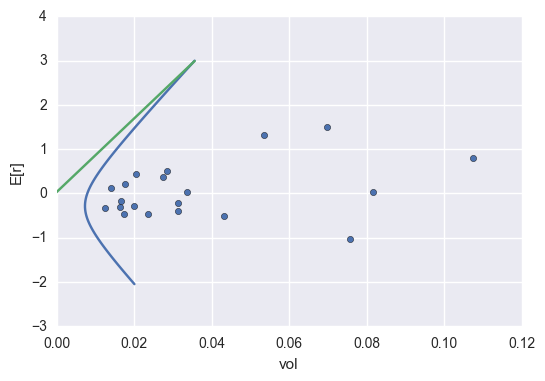

In [40]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP2, market_port2 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), all_scores.index)

Unlevered Minimum Variance Portfolio


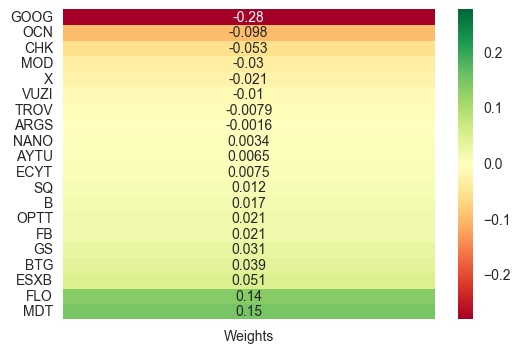

In [41]:
unlevered_MVP2 = unlever_portfolio(MVP2)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


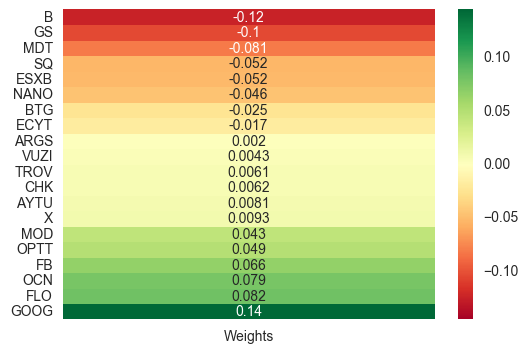

In [42]:
unlevered_market_port2 = unlever_portfolio(market_port2)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)